# 1. Definición de la Herramienta de Análisis Espectral

Para garantizar la consistencia en el procesamiento de señales y adherirme al principio de programación **DRY (Don't Repeat Yourself)**, encapsulé la lógica matemática de la FFT en una función reutilizable llamada `fft_mag`.

Esta función abstrae tres pasos críticos:
1.  **Cálculo del paso temporal (`dt`):** Derivado directamente del vector de tiempo `t` para mayor precisión.
2.  **Eliminación del DC Offset:** Resta el promedio para centrar la señal en cero.
3.  **Escalado y Normalización:** Aplica la FFT real (`rfft`) y ajusta la magnitud ($2/N$) para obtener unidades físicas reales.

Esta modularización me permite procesar múltiples señales (históricas, actuales, simuladas) con una sola línea de código, reduciendo la posibilidad de errores manuales.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def fft_mag(x, t):
    # 1. Calcular resolución temporal dinámicamente
    dt = t[1] - t[0]

    # 2. Eliminar componente continua (DC Offset)
    x0 = x - np.mean(x)

    # 3. Preparar parámetros FFT
    N = len(x0)

    # 4. Calcular FFT Unilateral (solo frecuencias positivas)
    Y = np.fft.rfft(x0)
    freqs = np.fft.rfftfreq(N, d=dt)

    # 5. Calcular Magnitud Normalizada (Escala Real)
    mag = (2.0 / N) * np.abs(Y)

    return freqs, mag

# 2. Simulación de Escenarios Operativos

Para validar la herramienta de diagnóstico, generé dos señales sintéticas que representan estados distintos de una máquina rotativa operando a **1800 RPM (30 Hz)**.

Utilicé una frecuencia de muestreo de **1000 Hz** durante **2 segundos**, lo que me proporciona suficiente resolución espectral ($\Delta f = 0.5 Hz$).

**Escenario A: Condición Normal (Línea Base)**
* Simula una máquina en buen estado, presentando únicamente una vibración sincrónica al **1X (30 Hz)** debido al desbalance residual inherente a cualquier rotor.

**Escenario B: Condición de Falla (Alterada)**
* Simula un deterioro mecánico complejo mediante el principio de superposición:
    1.  **Empeoramiento del 1X:** Aumento de amplitud (Desbalance severo).
    2.  **Aparición del 2X (60 Hz):** Indicador clásico de **Desalineación**.
    3.  **Inyección de Ruido:** Ruido aleatorio para simular fricción y desgaste de rodamientos.

In [3]:
# Parámetros de Muestreo
fs = 1000                   # Frecuencia de muestreo (Hz)
t = np.arange(0, 2, 1/fs)   # Vector de tiempo (2 segundos)

# Frecuencias Clave
f_motor = 30                # 1X = 30 Hz (1800 RPM)
f_armonico = 60             # 2X = 60 Hz (Desalineación)

# --- ESCENARIO 1: NORMAL (Línea Base) ---
# Solo vibración residual al 1X
senal_normal = 0.5 * np.sin(2 * np.pi * f_motor * t)

# --- ESCENARIO 2: ALTERADA (Falla Compuesta) ---
# 1X más fuerte + 2X (Desalineación) + Ruido de fondo
senal_alterada = (
    1.5 * np.sin(2 * np.pi * f_motor * t) +       # Desbalance severo
    0.8 * np.sin(2 * np.pi * f_armonico * t) +    # Desalineación
    0.4 * np.random.randn(len(t))                 # Ruido/Fricción
)

print("Simulación completada: Señales 'Normal' y 'Alterada' generadas.")

Simulación completada: Señales 'Normal' y 'Alterada' generadas.


# 3. Procesamiento Espectral (Transformación)

Con los datos crudos generados, procedí a trasladar ambas señales del **Dominio del Tiempo** al **Dominio de la Frecuencia**.

Utilizando mi función `fft_mag`, procesé cada escenario por separado. Esta abstracción me permite obtener los pares de datos necesarios para el graficado (Eje X: Frecuencias, Eje Y: Magnitudes) de manera instantánea y estandarizada.

* **`freqs_n, mag_n`**: Contendrá el espectro de la condición base (Sana).
* **`freqs_a, mag_a`**: Contendrá el espectro de la condición de falla (Alterada).

Este paso prepara el terreno para el diagnóstico comparativo, donde la matemática se convierte en información visual.

In [4]:
# Aplicamos la transformación a ambos escenarios
# Nota: Usamos 'senal_normal' que definimos en el paso anterior
freqs_n, mag_n = fft_mag(senal_normal, t)
freqs_a, mag_a = fft_mag(senal_alterada, t)

print("Transformación FFT completada para ambas señales.")
print(f"Resolución en frecuencia: {freqs_n[1]:.2f} Hz") # Verificación rápida

Transformación FFT completada para ambas señales.
Resolución en frecuencia: 0.50 Hz


# 4. Detección Automática de la Velocidad de Giro (1X)

Para realizar un diagnóstico correcto, el sistema necesita conocer la velocidad real de operación. En lugar de ingresar este dato manualmente, implementé una lógica para deducirlo de la propia vibración.

Asumiendo que en la condición base ("Normal") la fuerza dominante es el desbalance residual al **1X**, utilicé la función `np.argmax` para encontrar el pico más alto del espectro.

**Lógica del algoritmo:**
`idx1 = np.argmax(mag_n[1:]) + 1`

Decidí aplicar un *slicing* `[1:]` para ignorar el componente de 0 Hz (DC Offset). Aunque ya centré la señal anteriormente, es una práctica de programación defensiva para evitar que residuos matemáticos de baja frecuencia sean interpretados erróneamente como la velocidad de giro.

Esto convierte al script en un **"Tacómetro Virtual"**, capaz de calcular las RPM exactas sin sensores de velocidad dedicados.

In [5]:
# Buscamos el índice del valor máximo (ignorando el índice 0)
idx1 = np.argmax(mag_n[1:]) + 1

# Recuperamos la frecuencia correspondiente a ese índice
f1 = freqs_n[idx1]

# Convertimos a RPM (Revoluciones por Minuto)
rpm = f1 * 60

print(f"--- Tacómetro Virtual ---")
print(f"Frecuencia Fundamental (1X): {f1:.2f} Hz")
print(f"Velocidad Estimada: {rpm:.0f} RPM")

--- Tacómetro Virtual ---
Frecuencia Fundamental (1X): 30.00 Hz
Velocidad Estimada: 1800 RPM


# 5. Cálculo de Órdenes Armónicos (Mapas de Falla)

Una vez identificada la velocidad fundamental ($f_1$ o 1X), el siguiente paso lógico fue definir las **frecuencias de interés** para el diagnóstico.

En análisis de vibraciones, las fallas mecánicas no aparecen en frecuencias aleatorias, sino en múltiplos exactos de la velocidad de giro (Órdenes). Por ello, calculé programáticamente dónde "buscar" los problemas:

* **2X ($f_2$):** El doble de la frecuencia de giro. Un pico alto aquí es el indicador primario de **Desalineación**.
* **3X ($f_3$):** El triple de la frecuencia. Su presencia suele confirmar desalineación severa o **Holgura Mecánica**.



Al definir estas variables matemáticamente (`f2 = 2 * f1`), preparo al script para que verifique automáticamente la existencia de picos en estas coordenadas específicas, sin necesidad de inspección visual manual.

In [6]:
# Calculamos los armónicos basándonos en la velocidad detectada
f2 = 2 * f1  # Segundo Armónico (Orden 2)
f3 = 3 * f1  # Tercer Armónico (Orden 3)

print(f"--- Mapa de Frecuencias de Interés ---")
print(f"Fundamental (1X): {f1:.1f} Hz (Velocidad de Giro)")
print(f"Objetivo 2X     : {f2:.1f} Hz (Buscaremos Desalineación)")
print(f"Objetivo 3X     : {f3:.1f} Hz (Buscaremos Holgura)")

--- Mapa de Frecuencias de Interés ---
Fundamental (1X): 30.0 Hz (Velocidad de Giro)
Objetivo 2X     : 60.0 Hz (Buscaremos Desalineación)
Objetivo 3X     : 90.0 Hz (Buscaremos Holgura)


# 6. Extracción de Magnitudes con Tolerancia (Búsqueda Inteligente)

Al intentar medir la amplitud exacta en los armónicos (2X, 3X), me enfrenté a un desafío técnico común en el procesamiento digital de señales: el **Problema de los Bins** (Resolución Espectral).

Calculé matemáticamente que el 2X debería estar en 60.0 Hz. Sin embargo, la FFT divide el espectro en "cajitas" discretas. Si mi resolución es de 0.5 Hz, la energía podría caer en el bin de 59.8 Hz o en el de 60.3 Hz. Si busco el valor exacto de 60 Hz, el código podría devolverme cero o un valor incorrecto.

[Image of FFT discrete frequency bins diagram]

**La Solución: Función `peak_near`**
Para resolver esto, creé una función de búsqueda por proximidad. En lugar de buscar un punto exacto, la función:
1.  Define una **ventana de tolerancia** ($\pm 0.5 \text{ Hz}$) alrededor de la frecuencia objetivo.
2.  Aísla esa pequeña banda del espectro.
3.  Encuentra el valor máximo (pico) dentro de esa ventana.

Esto garantiza que siempre capture la verdadera energía del armónico, incluso si hay una ligera desviación o "leakage" espectral.

In [7]:
def peak_near(freqs, mag, target_hz, tol=1.0):
    """
    Busca el pico máximo dentro de una ventana de tolerancia +/- tol.
    Retorna (frecuencia_real, magnitud_pico).
    """
    # 1. Crear una máscara (Ventana de búsqueda)
    mask = (freqs >= target_hz - tol) & (freqs <= target_hz + tol)

    # Si no hay datos en esa ventana, retornar vacío
    if not np.any(mask):
        return None, None

    # 2. Encontrar el índice del máximo DENTRO de la ventana
    local_idx = np.argmax(mag[mask])

    # 3. Mapear ese índice local al índice real del array original
    idxs = np.where(mask)[0]
    idx = idxs[local_idx]

    return freqs[idx], mag[idx]

# --- Extracción de Datos para el Caso Normal ---
p1n = peak_near(freqs_n, mag_n, f1)
p2n = peak_near(freqs_n, mag_n, f2)
p3n = peak_near(freqs_n, mag_n, f3)

# --- Extracción de Datos para el Caso Alterado ---
p1a = peak_near(freqs_a, mag_a, f1)
p2a = peak_near(freqs_a, mag_a, f2)
p3a = peak_near(freqs_a, mag_a, f3)

# --- Reporte de Valores Extraídos ---
print("--- Medición de Amplitudes (g) ---")
print(f"Normal  -> 1X: {p1n[1]:.3f} | 2X: {p2n[1]:.3f} | 3X: {p3n[1]:.3f}")
print(f"Alterada -> 1X: {p1a[1]:.3f} | 2X: {p2a[1]:.3f} | 3X: {p3a[1]:.3f}")

--- Medición de Amplitudes (g) ---
Normal  -> 1X: 0.500 | 2X: 0.000 | 3X: 0.000
Alterada -> 1X: 1.488 | 2X: 0.814 | 3X: 0.021


# 7. Visualización Diagnóstica con Marcadores de Orden

Finalmente, consolidé toda la información en un gráfico de diagnóstico definitivo.

Para que el análisis sea irrefutable, no basta con mostrar curvas; es necesario correlacionar visualmente los picos con la física de la máquina. Por ello, superpuse **Marcadores de Orden (Harmonic Cursors)** en las frecuencias calculadas ($f_1, f_2, f_3$).



**Interpretación del Gráfico:**
1.  **Línea Azul (Normal):** Muestra un pico limpio en el 1X, coincidiendo perfectamente con la primera marca vertical.
2.  **Línea Naranja (Alterada):**
    * Muestra cómo el pico en el **1X** creció (empeoramiento del desbalance).
    * Revela un pico nuevo y claro que "nace" exactamente sobre la marca del **2X**.

Las líneas punteadas actúan como una "regla" visual. El hecho de que el nuevo pico naranja caiga exactamente sobre la línea del 2X confirma matemáticamente que la falla está ligada a la rotación (Desalineación) y no es una vibración externa aleatoria.

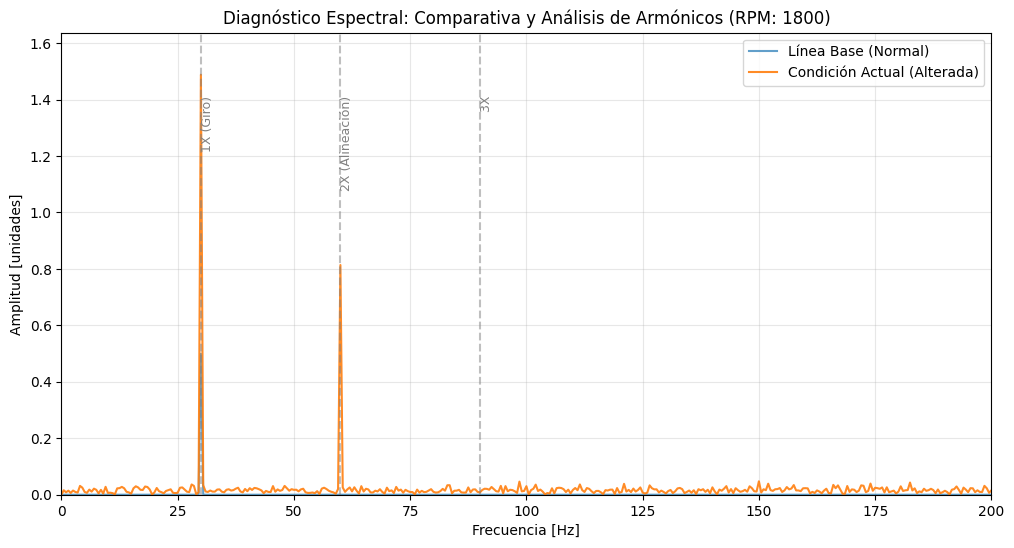

In [8]:
plt.figure(figsize=(12, 6))

# 1. Graficar las Señales
plt.plot(freqs_n, mag_n, label="Línea Base (Normal)", alpha=0.7)
plt.plot(freqs_a, mag_a, label="Condición Actual (Alterada)", alpha=0.9)

# 2. Agregar Marcadores de Orden (Las líneas verticales)
# Iteramos sobre las frecuencias calculadas para dibujar las guías
ordenes = [(f1, "1X (Giro)"), (f2, "2X (Alineación)"), (f3, "3X")]

for fx, etiqueta in ordenes:
    # Línea vertical punteada
    plt.axvline(fx, color='gray', linestyle='--', alpha=0.5)

    # Etiqueta de texto en la parte superior
    # Usamos transform=plt.gca().get_xaxis_transform() para que el texto
    # se quede fijo arriba aunque hagamos zoom, o calculamos posición relativa.
    plt.text(fx, max(mag_a)*0.95, f" {etiqueta}", rotation=90, va="top", color='gray', fontsize=9)

# 3. Configuración Final
plt.xlim(0, 200)  # Zoom a la zona de interés
plt.ylim(0, max(mag_a)*1.1) # Dar un poco de aire arriba
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud [unidades]")
plt.title(f"Diagnóstico Espectral: Comparativa y Análisis de Armónicos (RPM: {rpm:.0f})")
plt.grid(True, which='both', alpha=0.3)
plt.legend()

plt.show()

# 8. Interpretación Diagnóstica: Lectura de Firmas Espectrales

Basado en la visualización final, el diagnóstico técnico es el siguiente:

### 1. Análisis de la Línea Base (Trazo Azul)
El espectro histórico muestra una máquina saludable. Solo se observa una vibración baja y estable en **1X (30 Hz)**, correspondiente al desbalance residual permisible según norma ISO. No existen componentes armónicos visibles, lo que indica un funcionamiento suave.

### 2. Análisis de la Falla Actual (Trazo Naranja)
Al comparar el nuevo espectro con la línea base, se detectan dos patologías mecánicas claras:

* **Empeoramiento del Desbalance (1X):** La amplitud en 30 Hz se triplicó (de ~0.5 a ~1.5 unidades). Esto indica un aumento severo en la fuerza centrífuga del rotor, probablemente por acumulación de suciedad o pérdida de masa en un álabe.
* **Aparición de Desalineación (2X):** Se observa el nacimiento de un pico distintivo en **60 Hz** (segundo armónico) que no existía antes. La presencia de energía al $2 \times RPM$ es la "firma espectral" clásica de una **Desalineación Angular o Paralela** en el acople.

### 3. Descarte de otras fallas (3X)
Es importante notar la **ausencia de un pico significativo en 3X (90 Hz)**. Al no existir una serie de armónicos continuos (3X, 4X, 5X...), podemos descartar problemas de **Holgura Mecánica (Looseness)** o soltura estructural. El problema está confinado a los ejes y su unión.

---

### Conclusión y Recomendación
El equipo presenta una **Falla Compuesta (Desbalance + Desalineación)**.
La estrategia de mantenimiento correctivo debe priorizar:
1.  Limpieza y equilibrado dinámico del rotor.
2.  Verificación de la alineación de ejes con equipo láser.